# Assignment 01

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import requests
import random
import zipfile
import seaborn as sns
import os
import io
import matplotlib.pyplot as plt
from scipy.io import mmread
from bs4 import BeautifulSoup
random.seed(456)

## Question 3

### Choice: Katz centrality

**(a)** Write a function to compute a single node's centrality in a network

In [3]:
def compute_katz_centrality(G, n, alpha=0.001, beta=1.0, max_iter=1000, tol=1e-6):
    """
    Compute the Katz centrality for a single node n in graph G.
    
    Parameters:
    - G: NetworkX graph (Graph or DiGraph)
    - n: node in G
    - alpha: attenuation factor (float)
    - beta: initial centrality value (float)
    - max_iter: maximum number of iterations (int)
    - tol: tolerance for convergence (float)
    
    Returns:
    - centrality value for node n (float)
    """
    try:
        A = nx.adjacency_matrix(G)
    except Exception as e:
        raise ValueError("Failed to compute adjacency matrix.") from e
    
    # Alpha should be less the reciprocal of the largest eigenvalue
    try:
        eigenvalues = np.linalg.eigvals(A.toarray())
        max_eigenvalue = max(abs(eigenvalues))
        if max_eigenvalue == 0:
            raise ValueError("Adjacency matrix has zero eigenvalue. Cannot compute Katz centrality.")
    except Exception as e:
        raise ValueError("Failed to compute eigenvalues of the adjacency matrix") from e
    
    if alpha >= 1 / max_eigenvalue:
        raise ValueError(f"Alpha must be less than {1 / max_eigenvalue:.4f}.")
    
    # Initialize centrality vector
    n_nodes = G.number_of_nodes()
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)
    node_list = list(G.nodes())
    node_index = {node: idx for idx, node in enumerate(node_list)}
    
    for i in range(max_iter):
        x_old = x.copy()
        x = alpha * A.dot(x) + beta * ones
        # Check for convergence
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality failed to converge")
    
    idx = node_index[n]
    return x[idx]


In [4]:
G_er=nx.erdos_renyi_graph(500,0.5)
G_ba=nx.barabasi_albert_graph(500,3)
G_ws=nx.watts_strogatz_graph(500,10,0.5)
G_lb=nx.random_lobster(500,0.3,0.4)

In [5]:
compute_katz_centrality(G_ba,3)

1.057620574831503

**(b)** Augment with error handling:

i. A node that is not in the graph

ii. A graph that is not a networkx object

iii. A graph with no connectivity (or not enough connectivity to produce a valid
centrality result)

iv. Any situation that might produce numerical difficulties (e.g. dividing by
zero) for your chosen centrality measure

In [6]:
def compute_katz_centrality(G, n, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6):
    """
    Compute the Katz centrality for a single node n in graph G.
    
    Parameters:
    - G: NetworkX graph (Graph or DiGraph)
    - n: node in G
    - alpha: attenuation factor (float)
    - beta: initial centrality value (float)
    - max_iter: maximum number of iterations (int)
    - tol: tolerance for convergence (float)
    
    Returns:
    - centrality value for node n (float)
    """
    # Error handling:
    if not isinstance(G, (nx.Graph, nx.DiGraph)):
        raise TypeError("G must be a NetworkX graph.")
    if n not in G:
        raise ValueError(f"Node {n} is not in the graph.")
    if G.number_of_nodes() == 0:
        raise ValueError("Graph has no nodes.")
    if G.number_of_edges() == 0:
        print("Warning: Graph has no edges. Adjacency matrix is singular.")
    
    try:
        A = nx.adjacency_matrix(G)
    except Exception as e:
        raise ValueError("Failed to compute adjacency matrix.") from e
    
    # Alpha should be less the reciprocal of the largest eigenvalue
    try:
        eigenvalues = np.linalg.eigvals(A.toarray())
        max_eigenvalue = max(abs(eigenvalues))
        if max_eigenvalue == 0:
            raise ValueError("Adjacency matrix has zero eigenvalue. Cannot compute Katz centrality.")
    except Exception as e:
        raise ValueError("Failed to compute eigenvalues of the adjacency matrix") from e
    
    if alpha >= 1 / max_eigenvalue:
        raise ValueError(f"Alpha must be less than {1 / max_eigenvalue:.4f}.")
    
    # Initialize centrality vector
    n_nodes = G.number_of_nodes()
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)
    node_list = list(G.nodes())
    node_index = {node: idx for idx, node in enumerate(node_list)}
    
    for i in range(max_iter):
        x_old = x.copy()
        x = alpha * A.dot(x) + beta * ones
        # Check for convergence
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality failed to converge")    
    idx = node_index[n]
    return x[idx]


**(c)** Compare with networkx function

In [7]:
graphs = {}

G1 = nx.path_graph(5)
graphs['Path Graph'] = G1

# Disconnected
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4, 5])
G2.add_edges_from([(1, 2), (3, 4)])
graphs['Disconnected Graph'] = G2

# Empty
G3 = nx.Graph()
graphs['Empty Graph'] = G3

# Single node
G4 = nx.Graph()
G4.add_node(1)
graphs['Single Node Graph'] = G4

# Complete
G5 = nx.complete_graph(5)
graphs['Complete Graph'] = G5

# self-loop
G6 = nx.Graph()
G6.add_edge(1, 1)
G6.add_edge(1, 2)
G6.add_edge(2, 3)
graphs['Graph with Self-loop'] = G6


In [8]:
for name, G in graphs.items():
    print(f"Testing {name}")
    nodes = G.nodes()
    try:
        nx_katz = nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6, normalized=False)
    except Exception as e:
        nx_katz = {}
        print(f"NetworkX Katz centrality failed: {e}")
    
    for n in nodes:
        try:
            our_result = compute_katz_centrality(G, n)
        except Exception as e:
            our_result = str(e)
        nx_result = nx_katz.get(n, "Exception")
        print(f"Node {n}: Our result = {our_result}, NetworkX result = {nx_result}")
    print()

Testing Path Graph
Node 0: Our result = 1.123711321, NetworkX result = 1.12371124
Node 1: Our result = 1.237113372, NetworkX result = 1.23711321
Node 2: Our result = 1.247422642, NetworkX result = 1.24742248
Node 3: Our result = 1.237113372, NetworkX result = 1.23711321
Node 4: Our result = 1.123711321, NetworkX result = 1.12371124

Testing Disconnected Graph
Node 1: Our result = 1.1111111, NetworkX result = 1.111111
Node 2: Our result = 1.1111111, NetworkX result = 1.111111
Node 3: Our result = 1.1111111, NetworkX result = 1.111111
Node 4: Our result = 1.1111111, NetworkX result = 1.111111
Node 5: Our result = 1.0, NetworkX result = 1.0

Testing Empty Graph

Testing Single Node Graph
Node 1: Our result = Failed to compute eigenvalues of the adjacency matrix, NetworkX result = 1.0

Testing Complete Graph
Node 0: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 1: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 2: Our result = 1.66666

**(d)** Write **tests** function

In [15]:
def test_centrality_function(centrality_func,networkx_centrality_func):
    graphs = {}
    
    # connected
    G1 = nx.path_graph(5)
    graphs['Path Graph'] = G1
    
    # diconnected
    G2 = nx.Graph()
    G2.add_nodes_from([1, 2, 3, 4, 5])
    G2.add_edges_from([(1, 2), (3, 4)])
    graphs['Disconnected Graph'] = G2
    
    # empty
    G3 = nx.Graph()
    graphs['Empty Graph'] = G3
    
    # single node
    G4 = nx.Graph()
    G4.add_node(1)
    graphs['Single Node Graph'] = G4
    
    # complete
    G5 = nx.complete_graph(5)
    graphs['Complete Graph'] = G5
    
    # self-loop
    G6 = nx.Graph()
    G6.add_edge(1, 1)
    G6.add_edge(1, 2)
    G6.add_edge(2, 3)
    graphs['Graph with Self-loop'] = G6
    
    for name, G in graphs.items():
        print(f"Testing {name}")
        nodes = G.nodes()
        if len(nodes) ==0:
            print(f"This is an empty graph")
            print()
        else:
            try:
                nx_katz = networkx_centrality_func(
                    G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6, normalized=False
                )
            except Exception as e:
                nx_katz = {}
                print(f"NetworkX Katz centrality failed: {e}")
            
            for n in nodes:
                try:
                    our_result = centrality_func(
                        G, n, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6
                    )
                except Exception as e:
                    our_result = str(e)
                nx_result = nx_katz.get(n, "Exception")
                print(f"Node {n}: Our result = {our_result}, NetworkX result = {nx_result}")
            print()


In [14]:
test_centrality_function(compute_katz_centrality,nx.katz_centrality)

Testing Path Graph
Node 0: Our result = 1.123711321, NetworkX result = 1.12371124
Node 1: Our result = 1.237113372, NetworkX result = 1.23711321
Node 2: Our result = 1.247422642, NetworkX result = 1.24742248
Node 3: Our result = 1.237113372, NetworkX result = 1.23711321
Node 4: Our result = 1.123711321, NetworkX result = 1.12371124

Testing Disconnected Graph
Node 1: Our result = 1.1111111, NetworkX result = 1.111111
Node 2: Our result = 1.1111111, NetworkX result = 1.111111
Node 3: Our result = 1.1111111, NetworkX result = 1.111111
Node 4: Our result = 1.1111111, NetworkX result = 1.111111
Node 5: Our result = 1.0, NetworkX result = 1.0

Testing Empty Graph
This is an empty graph

Testing Single Node Graph
Node 1: Our result = Exception: Failed to compute eigenvalues of the adjacency matrix, NetworkX result = 1.0

Testing Complete Graph
Node 0: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 1: Our result = 1.6666665521342054, NetworkX result = 1.66666638033

## Question 4

### Construct a DAG (directed acyclic graph) of the curriculum

**(a)** Scrape the course descriptions and prerequisites of each course

In [19]:
catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
catalog_html = catalog_res.text
soup = BeautifulSoup(catalog_html)
soup_alpha_div = soup.find('div', id="atozindex")
first_ul = soup_alpha_div.find('ul')
first_bullet = first_ul.find('li')
print('\n Finally, we can get the link and its href (the partial URL that points to the accounting courses):')
print(first_bullet.a.get('href'))


 Finally, we can get the link and its href (the partial URL that points to the accounting courses):
/course-descriptions/acct/


In [20]:
department_hrefs = []
for ul in soup_alpha_div.find_all('ul'):
    for li in ul.find_all('li'):
        department_hrefs.append(li.a.get('href'))

In [21]:
len(department_hrefs)

229

In [42]:
random.seed(456)
my_href = random.choice(department_hrefs)
my_full_url = 'https://catalog.northeastern.edu' + my_href
print(my_full_url)
dept_html = requests.get(my_full_url).text

https://catalog.northeastern.edu/course-descriptions/pols/


In [43]:
def get_course_titles_and_descriptions(dept_html):
    descriptions=[] 
    course_list=[]
    soup = BeautifulSoup(dept_html)
    site_title_dept = soup.find('div', id="site-title")
    courses=soup.find('div',id='textcontainer')
    course_elements = soup.select('#textcontainer > div > div > p.courseblocktitle.noindent > strong')
    description_elements = soup.select('#textcontainer > div > div > p.cb_desc')
    for course, description in zip(course_elements, description_elements):
        course_list.append(course.get_text(strip=True))
        descriptions.append(description.get_text(strip=True))
    courses_df = pd.DataFrame({
        'course': course_list,
        'description': descriptions
    })
    return site_title_dept,courses_df

In [44]:
site_title_dept, courses_df=get_course_titles_and_descriptions(dept_html)
courses_df.tail()

,course,description
106,POLS 9000. PhD Candidacy Achieved. (0 Hours),Indicates successful completion of the doctora...
107,POLS 9986. Research. (0 Hours),Offers an opportunity to conduct full-time res...
108,POLS 9990. Dissertation Term 1. (0 Hours),Offers dissertation supervision by individual ...
109,POLS 9991. Dissertation Term 2. (0 Hours),Offers dissertation supervision by members of ...
110,POLS 9996. Dissertation Continuation. (0 Hours),Offers continued dissertation supervision by i...


- Scrape POLS department

In [134]:
prerequisites = {}
soup = BeautifulSoup(dept_html, 'html.parser')

for course in soup.find_all('div', class_='courseblock'):
    course_code = course.find('p', class_='courseblocktitle noindent').text.replace('\xa0', ' ').split('. ')[0].strip()
    course_title = course.find('p', class_='courseblocktitle noindent').text.replace('\xa0', ' ').split('. ')[1].strip()
    prereq_list = []
    prereq_link_list = []

    # Look for p tags with 'courseblockextra noindent' and <strong>Prerequisite(s):</strong>
    for text_line in course.find_all('p', class_='courseblockextra noindent'):
        if text_line.find('strong') and 'Prerequisite(s):' in text_line.find('strong').text:
            a_tags = text_line.find_all('a')
            for tag in a_tags:
                href = 'https://catalog.northeastern.edu' + tag.get('href')
                prereq_link_list.append(href)
                onclick_value = tag.get('onclick')
                if onclick_value:
                    prereq = onclick_value.split(',')[-1][2:-3]
                    prereq_list.append(prereq)

    prerequisites[course_code] = {
        'title': course_title,
        'prerequisites': prereq_list,
        'prerequisites_link': prereq_link_list
    }


In [135]:
course_rows = []
for course_code, details in prerequisites.items():
    course_title = details['title']
    prerequisites_list = details['prerequisites']
    prerequisites_link_list = details['prerequisites_link']    
    if prerequisites_list:
        for prereq, link in zip(prerequisites_list, prerequisites_link_list):
            course_rows.append({
                'code': course_code,
                'title': course_title,
                'prerequisite': prereq,
                'prerequisite_link': link,
                'dept_link': my_full_url
            })
    else:
        course_rows.append({
            'code': course_code,
            'title': course_title,
            'prerequisite': None,
            'prerequisite_link': None,
            'dept_link': my_full_url
        })
df_prereq_pol = pd.DataFrame(course_rows)#.dropna(subset=['prerequisite'])
df_prereq_pol.to_csv('df_prereq_pol.csv',header=True,index=False)

In [136]:
df_prereq_pol.tail()

,code,title,prerequisite,prerequisite_link,dept_link
131,POLS 9000,PhD Candidacy Achieved,None,None,https://catalog.northeastern.edu/course-descri...
132,POLS 9986,Research,None,None,https://catalog.northeastern.edu/course-descri...
133,POLS 9990,Dissertation Term 1,POLS 9000,https://catalog.northeastern.edu/search/?P=POL...,https://catalog.northeastern.edu/course-descri...
134,POLS 9991,Dissertation Term 2,POLS 9990,https://catalog.northeastern.edu/search/?P=POL...,https://catalog.northeastern.edu/course-descri...
135,POLS 9996,Dissertation Continuation,POLS 9991,https://catalog.northeastern.edu/search/?P=POL...,https://catalog.northeastern.edu/course-descri...


- Scrape all department

In [17]:
def scrape_courses(department_hrefs):
    all_course_rows = []    
    for dept_link in department_hrefs:
        response = requests.get('https://catalog.northeastern.edu' + dept_link)
        dept_html = response.content
        soup = BeautifulSoup(dept_html, 'html.parser')
        
        for course in soup.find_all('div', class_='courseblock'):
            course_code = course.find('p', class_='courseblocktitle noindent').text.replace('\xa0', ' ').split('. ')[0].strip()
            course_title = course.find('p', class_='courseblocktitle noindent').text.replace('\xa0', ' ').split('. ')[1].strip()
            prereq_list = []
            prereq_link_list = []
            
            # Look for 'courseblockextra noindent' with <strong>Prerequisite(s):</strong>
            prerequisite_found = False
            for text_line in course.find_all('p', class_='courseblockextra noindent'):
                if text_line.find('strong') and 'Prerequisite(s):' in text_line.find('strong').text:
                    prerequisite_found = True
                    a_tags = text_line.find_all('a')
                    for tag in a_tags:
                        href = 'https://catalog.northeastern.edu' + tag.get('href')
                        prereq_link_list.append(href)
                        onclick_value = tag.get('onclick')
                        if onclick_value:
                            prereq = onclick_value.split(',')[-1][2:-3]
                            prereq_list.append(prereq)
            
            # Add courses with or without prerequisites
            if prereq_list:
                for prereq, link in zip(prereq_list, prereq_link_list):
                    all_course_rows.append({
                        'code': course_code,
                        'title': course_title,
                        'prerequisite': prereq,
                        'prerequisite_link': link,
                        'dept_link': dept_link
                    })
            elif not prerequisite_found:
                all_course_rows.append({
                    'code': course_code,
                    'title': course_title,
                    'prerequisite': None,
                    'prerequisite_link': None,
                    'dept_link': dept_link
                })

    return all_course_rows

In [22]:
all_course_rows=scrape_courses(department_hrefs)

In [157]:
df_prereq = pd.DataFrame(all_course_rows)
df_prereq.to_csv('df_prereq.csv',header=True,index=False)

In [25]:
df_prereq = pd.DataFrame(all_course_rows)
df_prereq.head()

,code,title,prerequisite,prerequisite_link,dept_link
0,ACCT 1201,Financial Accounting and Reporting,None,None,/course-descriptions/acct/
1,ACCT 1209,Financial Accounting and Reporting,None,None,/course-descriptions/acct/
2,ACCT 1990,Elective,None,None,/course-descriptions/acct/
3,ACCT 2301,Profit Analysis for Managers and Advisors,ACCT 1201,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/
4,ACCT 2301,Profit Analysis for Managers and Advisors,ACCT 1209,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/


**(b)** networkx directed graph of all curriculumn
- For here, start from the nodes that have degree at least 1

/tmp/ipykernel_29401/541122629.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(unique_depts))


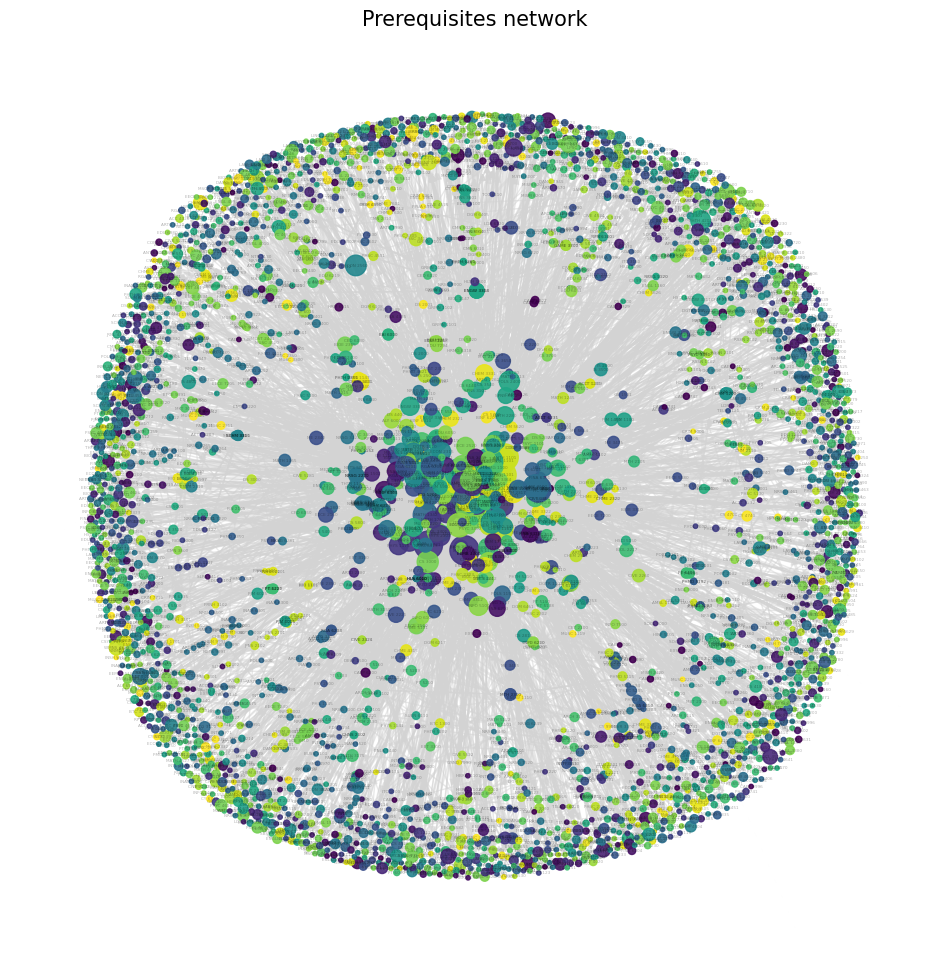

In [160]:
df_filtered = df_prereq.dropna(subset=['prerequisite'])
df_filtered = df_filtered[~(df_filtered.code==df_filtered.prerequisite)]
df_grouped = df_filtered.groupby(['code', 'prerequisite']).size().reset_index(name='weight')
G_preq = nx.DiGraph()

for _, row in df_grouped.iterrows():
    G_preq.add_edge(row['prerequisite'], row['code'], weight=row['weight'])
degrees = dict(G_preq.degree())
node_size = [degrees[node]*10 for node in G_preq.nodes()] 
dept_links_code = df_filtered.set_index('code')['dept_link'].to_dict()
dept_links_prereq = df_filtered.set_index('prerequisite')['dept_link'].to_dict()
dept_links = {**dept_links_code, **dept_links_prereq}


for prereq in df_filtered['prerequisite'].unique():
    if prereq not in dept_links:
        dept_links[prereq] = 'Unknown' 


unique_depts = list(set(dept_links.values())) 
cmap = cm.get_cmap('viridis', len(unique_depts))
colors = [cmap(i) for i in np.linspace(0, 1, len(unique_depts))]
dept_color_dict = {dept: colors[i] for i, dept in enumerate(unique_depts)}
node_colors = [dept_color_dict.get(dept_links.get(node, 'Unknown'), (0.5, 0.5, 0.5, 1)) for node in G_preq.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_preq, seed=42)
nx.draw_networkx_nodes(G_preq, pos, node_size=node_size, node_color=node_colors, alpha=0.9)
edges = G_preq.edges(data=True)
edge_weights = [G_preq[u][v]['weight'] for u, v in G_preq.edges()]
nx.draw_networkx_edges(G_preq, pos, width=[weight for weight in edge_weights], alpha=0.5,edge_color='lightgrey')
nx.draw_networkx_labels(G_preq, pos, font_size=3,alpha=0.3)

for dept, color in dept_color_dict.items():
    plt.scatter([], [], c=[color], label=dept, s=100)

plt.title('Prerequisites network', size=15)
plt.axis('off')
plt.show()

**(c)** Which department has the most prerequisites per course


- The anthropology department has the most prerequisites per course, then is english and english writing

In [161]:
df_pre_count.head()

,code,title,prerequisite,prerequisite_link,dept_link,pre_count
0,ACCT 2301,Profit Analysis for Managers and Advisors,ACCT 1201,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/,1
1,ACCT 2301,Profit Analysis for Managers and Advisors,ACCT 1209,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/,1
2,ACCT 3304,Business Law and Professional Ethics,ACCT 2301,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/,1
3,ACCT 3401,Financial Reporting and Analysis 1,ACCT 2301,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/,1
4,ACCT 3402,Financial Reporting and Financial Statement An...,ACCT 2301,https://catalog.northeastern.edu/search/?P=ACC...,/course-descriptions/acct/,1


In [162]:
df_pre_count=df_prereq.copy()
df_pre_count['pre_count']=0
df_pre_count.loc[~df_pre_count.prerequisite.isna(),'pre_count']=1
df_pre_group=df_pre_count[['code','dept_link','pre_count']].groupby(
    'dept_link').agg({
    'pre_count': 'sum',
    'code':'nunique'}
    ).reset_index()
df_pre_group['preq_ratio']=df_pre_group['pre_count']/df_pre_group['code']
df_pre_group=df_pre_group.sort_values('preq_ratio',ascending=False)
df_pre_group['dept_link']=df_pre_group['dept_link'] # or 'https://catalog.northeastern.edu'+ dept_link
df_pre_group.head()

,dept_link,pre_count,code,preq_ratio
16,/course-descriptions/anth/,97,34,2.852941
83,/course-descriptions/engl/,293,122,2.401639
85,/course-descriptions/engw/,44,20,2.200000
219,/course-descriptions/spns/,54,25,2.160000
202,/course-descriptions/psyc/,199,98,2.030612


**(d)** Longest chain of prerequisites

There are some cycles indeed, and it makes sense for instance:
- SPNS 3601. Exploring Spoken Spanish. (4 Hours) could have 3602 as prerequisite
- SPNS 3602. Introduction to Spanish Linguistics. (4 Hours) could have 3601 as prerequisite

In [169]:
try:
    while True:
        cycle = list(nx.find_cycle(G_preq, orientation="original"))
        print(cycle)
        if not cycle:
            break
        edge_to_remove = cycle[0]
        G_preq.remove_edge(edge_to_remove[0], edge_to_remove[1])
except nx.NetworkXNoCycle:
    print("No more cycles found")

[('SPNS 3602', 'SPNS 3603', 'forward'), ('SPNS 3603', 'SPNS 3602', 'forward')]
No more cycles found


- Thus, after removing the cycle, the longest chain is

In [170]:
nx.dag_longest_path(G_preq)


['BIOL 1107',
 'BIOL 1113',
 'PHSC 2301',
 'PHSC 2303',
 'HSCI 1105',
 'NRSG 2220',
 'NRSG 3323',
 'NRSG 3320',
 'NRSG 3420',
 'NRSG 4502',
 'NRSG 4995']

## Question 5

Choice: download the data of Tech routers network

In [192]:
url = "https://nrvis.com/download/data/tech/tech-routers-rf.zip"
response = requests.get(url)
response.raise_for_status() 
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    mtx_filename = next((f for f in thezip.namelist() if f.endswith('.mtx')), None)
    if mtx_filename is None:
        raise FileNotFoundError("No .mtx file found in the ZIP archive.")
    with thezip.open(mtx_filename) as mtx_file:
        adjacency_matrix = mmread(mtx_file)
G = nx.from_scipy_sparse_array(adjacency_matrix)

**(b)** Compare with randomized network

In [218]:
def plot_network_properties(G, binned=True, bins=20):
    """
    Plots the degree, clustering coefficient, and betweenness centrality distributions 
    of the graph G. Optionally applies binning.
    
    Parameters:
        G (networkx.Graph): The input graph.
        binned (bool): Whether to apply binning. Default is True.
        bins (int): Number of bins for the binning. Default is 20.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
    
    degree_sequence = [d for n, d in G.degree()]
    clustering_coeffs = list(nx.clustering(G).values())
    betweenness_centrality = list(nx.betweenness_centrality(G).values())
    
    def bin_data(data, num_bins):
        bins = np.linspace(min(data), max(data), num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2 
        bin_counts, _ = np.histogram(data, bins=bins) 
        bin_frequency = bin_counts / len(data) 
        return bin_centers, bin_frequency

    if binned:
        degree_bin_centers, degree_binned_freq = bin_data(degree_sequence, bins)
        axes[0].scatter(degree_bin_centers, degree_binned_freq, color='salmon', s=30)
    else:
        unique_degrees, degree_counts = np.unique(degree_sequence, return_counts=True)
        degree_frequency = degree_counts / len(G.nodes())
        axes[0].scatter(unique_degrees, degree_frequency, edgecolor='black')
    
    axes[0].set_title('Degree (Log-Log Scale)')
    axes[0].set_xlabel('Degree (log scale)')
    axes[0].set_ylabel('Frequency (log scale)')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')

    if binned:
        cc_bin_centers, cc_binned_freq = bin_data(clustering_coeffs, bins)
        axes[1].scatter(cc_bin_centers, cc_binned_freq, color='salmon', s=30)
    else:
        unique_ccs, cc_counts = np.unique(clustering_coeffs, return_counts=True)
        cc_frequency = cc_counts / len(G.nodes())
        axes[1].scatter(unique_ccs, cc_frequency, edgecolor='black')
    
    axes[1].set_title('Clustering Coefficient')
    axes[1].set_xlabel('Clustering Coefficient')
    axes[1].set_ylabel('Frequency')
    
    if binned:
        bc_bin_centers, bc_binned_freq = bin_data(betweenness_centrality, bins)
        axes[2].scatter(bc_bin_centers, bc_binned_freq, color='salmon', s=30)
    else:
        unique_bcs, bc_counts = np.unique(betweenness_centrality, return_counts=True)
        bc_frequency = bc_counts / len(G.nodes())
        axes[2].scatter(unique_bcs, bc_frequency, edgecolor='black')
    
    axes[2].set_title('Betweenness Centrality')
    axes[2].set_xlabel('Betweenness Centrality')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

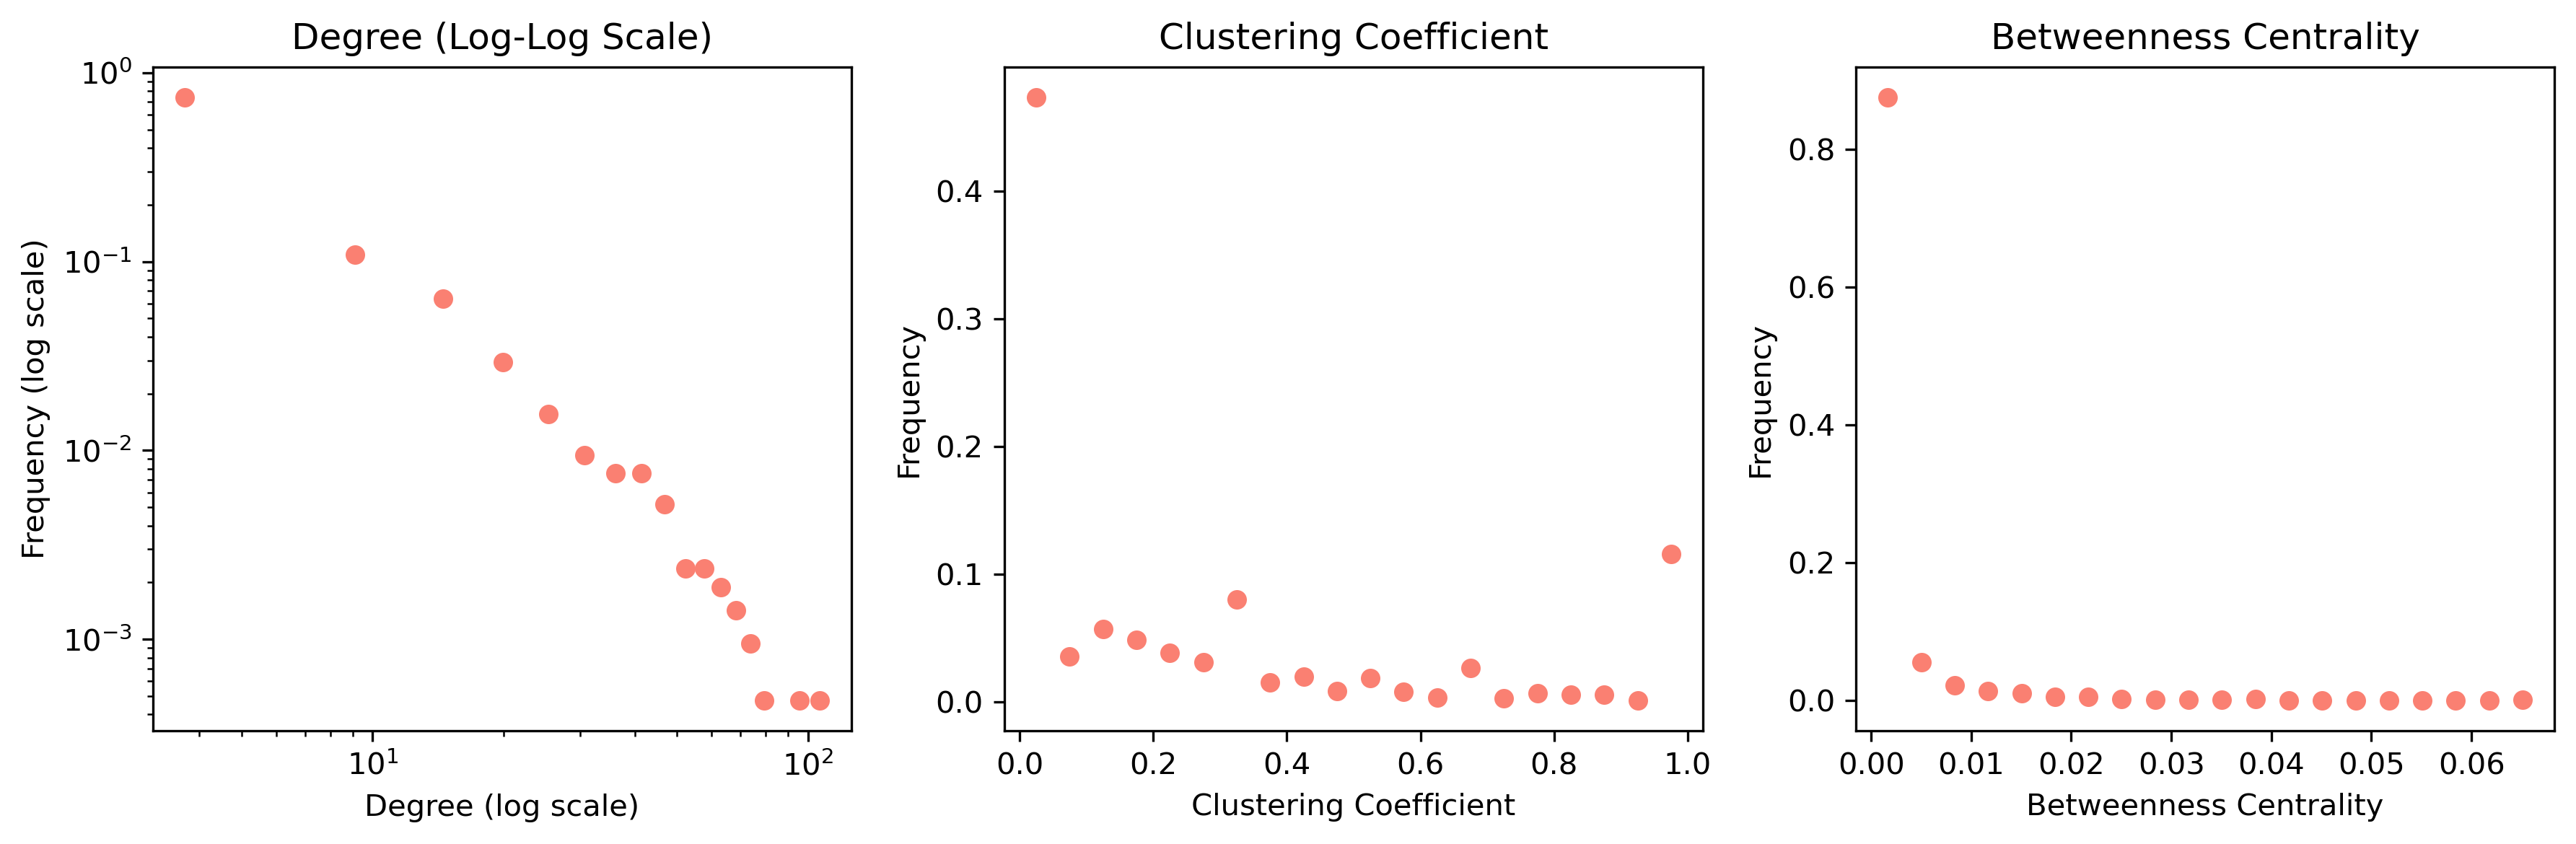

In [219]:
plot_network_properties(G, binned=True) 

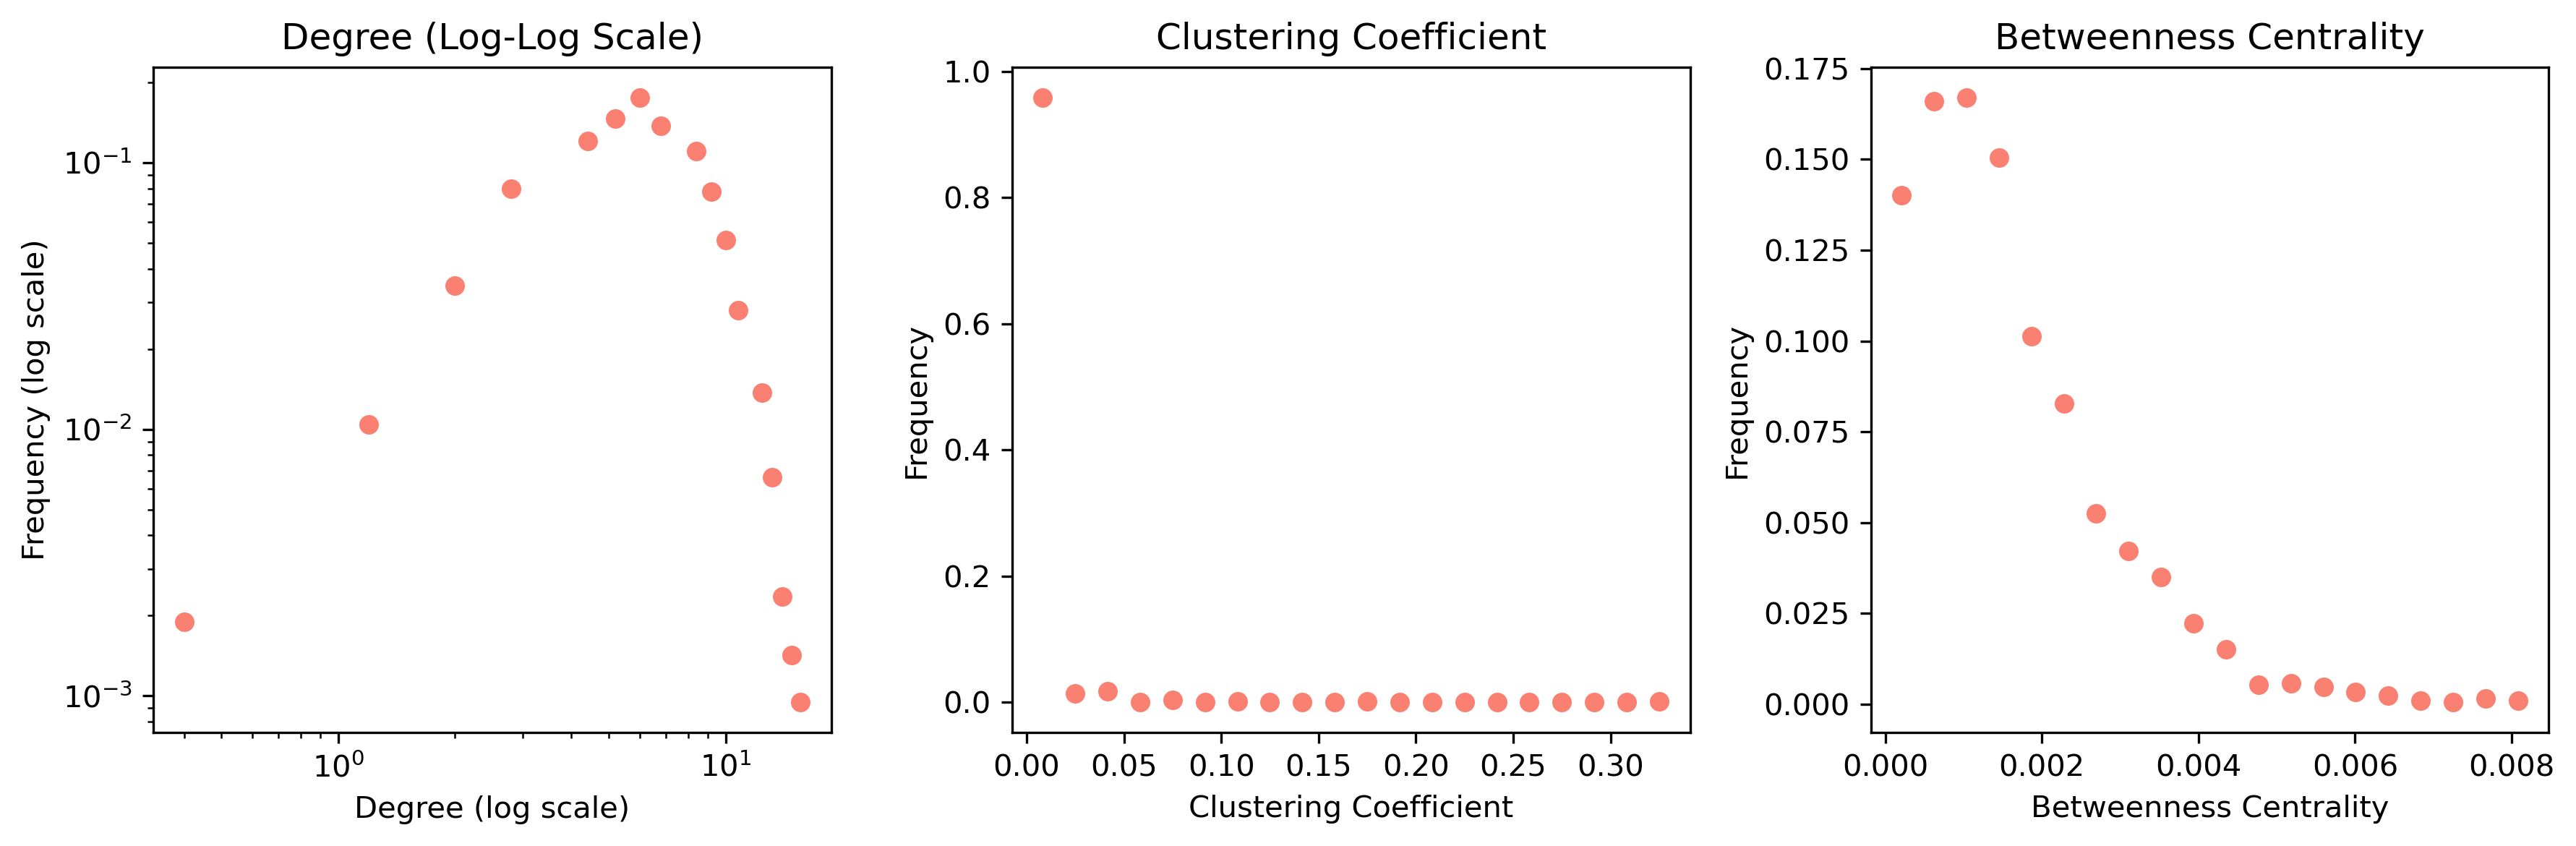

In [220]:
# Gnm random network
degree_sequence = [d for n, d in G.degree()]
G_nm=nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
plot_network_properties(G_nm, binned=True) 

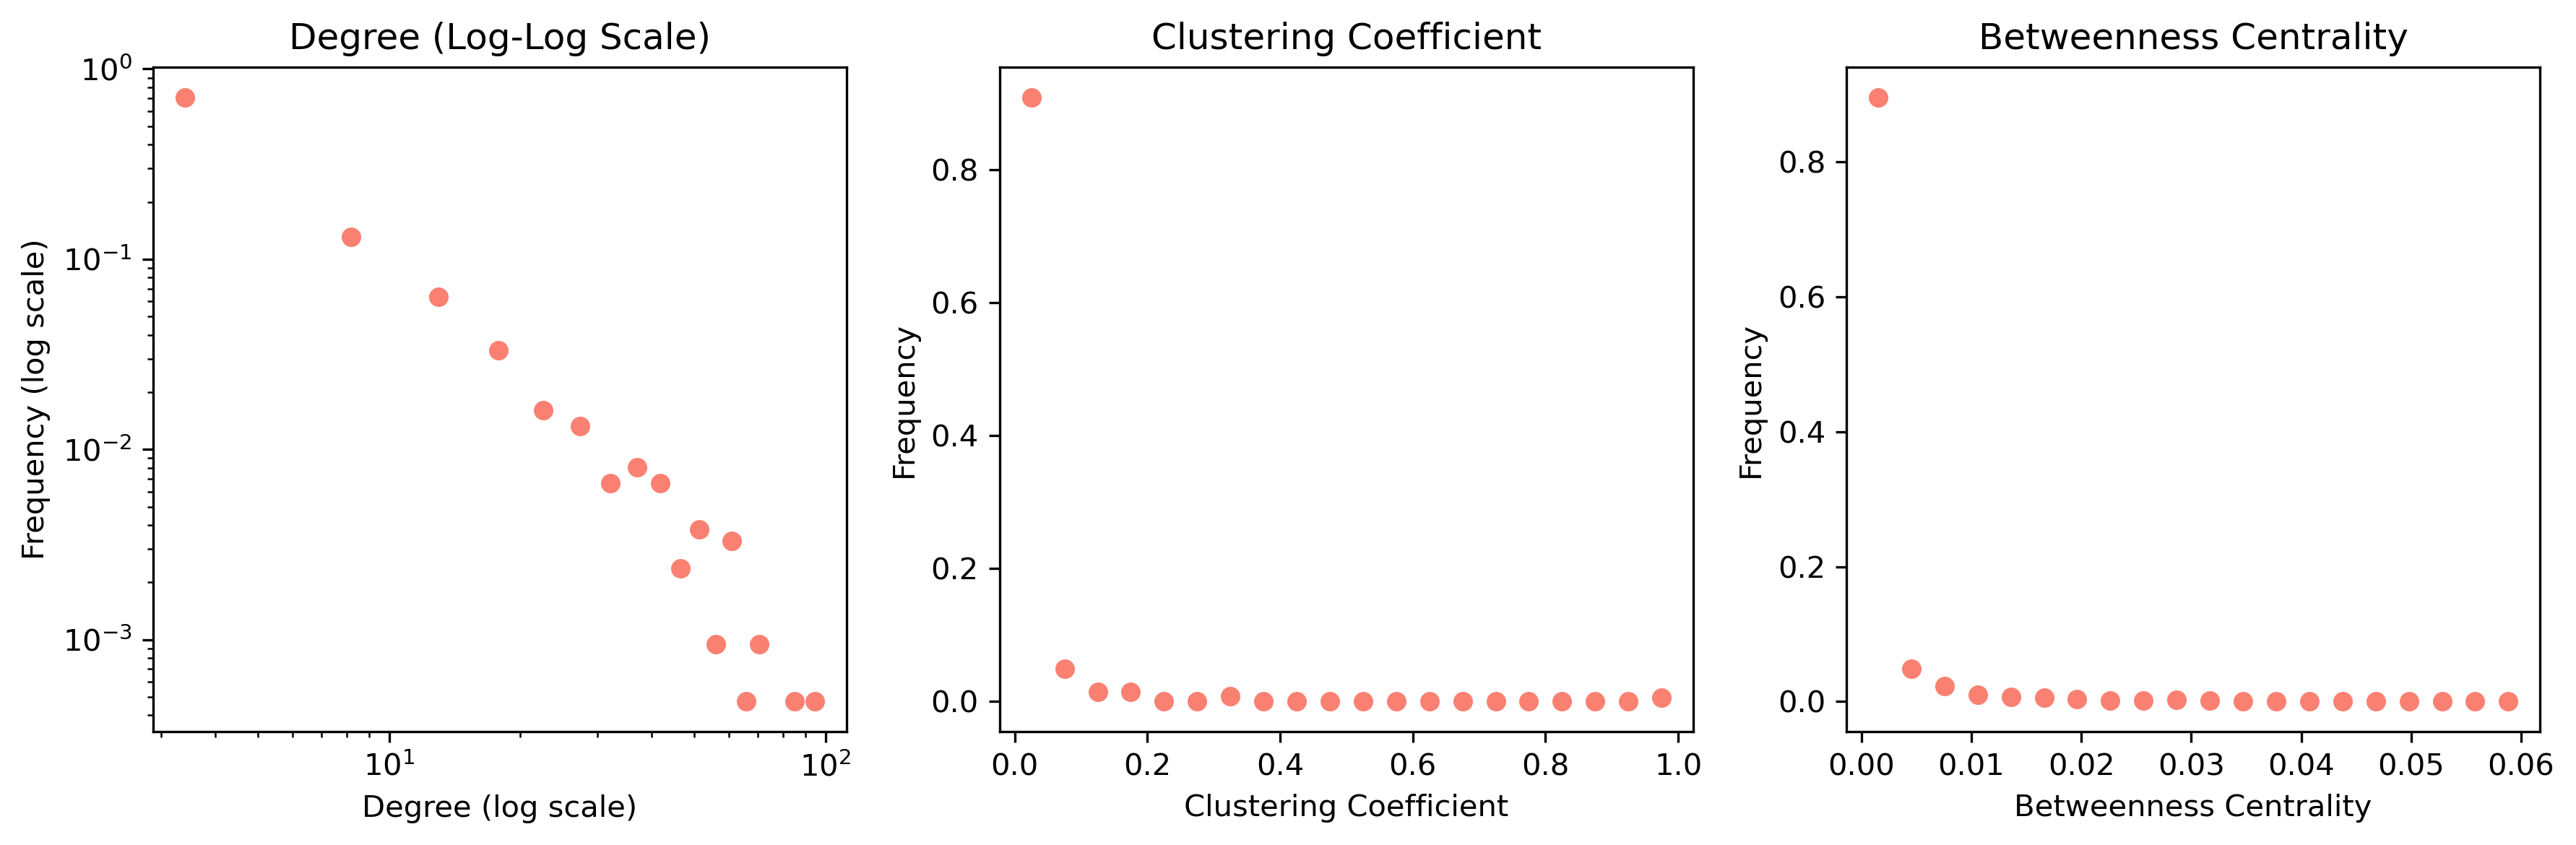

In [221]:
# configuration model
degree_sequence = [d for n, d in G.degree()]
G_config = nx.configuration_model(degree_sequence)
G_config = nx.Graph(G_config)
G_config.remove_edges_from(nx.selfloop_edges(G_config))
plot_network_properties(G_config, binned=True) 